In [140]:
#pip install spotipy --upgrade              # Uncomment this and run it if you haven't installed spotipy before


In [1]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import clientID, clientSEC           # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [2]:
# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=clientID, client_secret=clientSEC)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [3]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

country_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up **main dataframe** with data from **FIRST** file
string = str(glob.glob(path)[0])                                 # in the folder.
year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
                                                                 # **file name**
country_tracks_df[['Year']] = year_month[0]
country_tracks_df[['Month']] = year_month[1]
country_tracks_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1]) 
Tot_Streams1 = country_tracks_df['Streams'].sum()                # Find out total streams in FIRST file in folder.
country_tracks_df[['Stream %']] = country_tracks_df['Streams'] / Tot_Streams1    # New column with % of streams

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        #print (year_month)
        Tot_Streams2 = temp_df['Streams'].sum()
        temp_df[['Year']] = year_month[0]
        temp_df[['Month']] = year_month[1]
        temp_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1])
        temp_df[['Stream %']] = temp_df['Streams'] / Tot_Streams2
        country_tracks_df = pd.concat([country_tracks_df,        # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.  ¿¿¿???? 
        

                                                 
country_tracks_df = country_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month




                                                                 # You should get 4,800 rows (24 months x 200 
                                                                 # tracks per month)
country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %
0,1,TVTB (feat. Dark Polo Gang),Fedez,2907906,https://open.spotify.com/track/3J1ZGGnDdhfAN3z...,2019,01,2019-01,0.027133
1,2,Stamm Fort (feat. Sfera Ebbasta),Luche,2601065,https://open.spotify.com/track/7iTTQvztpfrDneV...,2019,01,2019-01,0.024270
2,3,È sempre bello,Coez,2360029,https://open.spotify.com/track/18LXrvm337xqvFx...,2019,01,2019-01,0.022021
3,4,IL CIELO NELLA STANZA (feat. NSTASIA),Salmo,2220963,https://open.spotify.com/track/2fkVZYFv9hOejIs...,2019,01,2019-01,0.020724
4,5,Calma - Remix,Pedro Capó,2039849,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,01,2019-01,0.019034
...,...,...,...,...,...,...,...,...,...
195,196,SICKO MODE,Travis Scott,226140,https://open.spotify.com/track/2xLMifQCjDGFmkH...,2020,12,2020-12,0.002623
196,197,Lacri-ma,Gazzelle,225380,https://open.spotify.com/track/0N6QZADGv1zv3Jb...,2020,12,2020-12,0.002615
197,198,Shallow,Lady Gaga,224420,https://open.spotify.com/track/2VxeLyX666F8uXC...,2020,12,2020-12,0.002603
198,199,"Alright (feat. Emis Killa, Geolier)",Gemitaiz,224156,https://open.spotify.com/track/7hhg8fAx3sc2zOO...,2020,12,2020-12,0.002600


In [6]:
# Get Track IDs
track_names = country_tracks_df['Track Name'].to_list()           # Set up list of tracks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)                                   # nan if nothing

TVTB (feat. Dark Polo Gang) song ID : 3J1ZGGnDdhfAN3z4qRRonq
Stamm Fort (feat. Sfera Ebbasta) song ID : 7iTTQvztpfrDneVSX9IGBD
È sempre bello song ID : 6IdiuMw1FSAvU3e6bgWQVX
IL CIELO NELLA STANZA (feat. NSTASIA) song ID : 2fkVZYFv9hOejIsLzZy8ad
Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
Happy Birthday song ID : 2bnTgPFD75vbq1AhxLJfMu
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Baila Baila Baila song ID : 7mWFF4gPADjTQjC97CgFVt
90MIN song ID : 3Ls9yKzshQye18Tx2AvOb6
Hola (I Say) (feat. Tom Walker) song ID : 42LrSpEHmXHfjEH8NeiQQi
Cambiare Adesso song ID : 2xjxaKiYssIdDU6DCPpZPt
Torna a casa song ID : 3590AAEoqH50z4UmhMIY85
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Ngopp'A Luna song ID : 2CfWwaXsDgNxBE4lTJZC0A
Cascare nei tuoi occhi song ID : 60oJSn5MTG2VNvCJKwd65M
Holding out for You (feat. Zara Larsson) song ID : 6eiVP1Q0XaevZEZnQFpYEH
Senza Di Me (feat. Venerus & Franco126) song ID : 3xGD5KhnizETt7KQwxtUAc
Stanza Singola (feat. Tommaso Paradiso) song ID : 23hpOtox5sIuRqVBVVJ

Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
scuol4 song ID : 1V7hvLe3fpZTMoqKLkBDgW
Uh Ah Hey song ID : 2zsJ7dZdvtmUBDOuRSqQ5h
Figurati noi (feat. Emma Muscat) song ID : 5AQ7Wuc1UGCROIifaInqdV
IDGAF song ID : 76cy1WJvNGJTj78UqeA5zr
Purple Rain (feat. Gemitaiz & Frenetik&Orang3) song ID : 286i6Yq99ALCLHXDofuTVL
Pesto song ID : 4UHDgfDtSSv9SqyfEFr4sF
Say My Name song ID : 7H6ev70Weq6DdpZyyTmUXk
Buongiornissimo song ID : 2vmjhinZGxfcN5KOkFnGYQ
L'altra dimensione song ID : 36ONZ2CvV8KsLPapNPGTqa
Chic song ID : 4wVOKKEHUJxHCFFNUWDn0B
Solo (feat. Demi Lovato) song ID : 6kPJZM97LwdG9QIsT7khp6
Irraggiungibile (feat. Federica Carta) song ID : 03PDOt4cRKQgpYfA9I9wnC
Don't Stop Me Now - Remastered 2011 song ID : 7hQJA50XrCWABAu5v6QZ4i
These Days (feat. Jess Glynne, Macklemore & Dan Caplen) song ID : 5CLGzJsGqhCEECcpnFQA8x
PELLE D'OCA song ID : 7BIoYqwZlcKosZr1ceAhuV
Rollin' song ID : 1xqRKo0SDFDO5Jy8yEVD0X
Un posto bellissimo song ID : 2qqDDnzVeEk4Yf0rJPaM9h
Che Ci Faccio song ID : 3yhRpGAdByLRLN

Peter Pan - Vuoi volare con me? song ID : 3qbMJGhSNdeKdz407PA6x4
Sopra song ID : 5d5hgQCHyzkPrxWejb69St
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Nothing Breaks Like a Heart (feat. Miley Cyrus) song ID : 27rdGxbavYJeBphck5MZAF
Ludovico song ID : 1BncfTJAWxrsxyT9culBrj
Let Me Down Slowly song ID : 2qxmye6gAegTMjLKEBoR3d
Musica che resta song ID : 59nLT8Be6wKKhgfJKkLN0j
Racconterò di te song ID : 1c1f9Xtqp0dwUkXYndACqe
PIOGGIA song ID : 2unmie5sfHDGwSQO9jEok4
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
Gli occhi della tigre song ID : 5pL8J6weoydzXglhsoJ6Vw
Thunderclouds song ID : 4lJNen4SMTIJMahALc3DcB
Se Piovesse Il Tuo Nome song ID : 0FNRyMufs8Ox03TtaoyCjH
Money Rain song ID : 1kuSXR7D6H02EsHcK4ULFD
Beatrix Kiddo (feat. Vale Lambo) song ID : 3NR8xopBopMRrl8yA3dOyI
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Another One Bites The Dust - Remastered 2011 song ID : 57JVGBtBLCfHw2muk5416J
Nuovi Jeans song ID : 0N1pKkjhVwKZWFLF47R1tv
Fame song ID : 1PehfI

Vertigini song ID : 1Oou7m2VuxCDSOdqsu07TU
Tesla (feat. Sfera Ebbasta & DrefGold) song ID : 093RgZ7RXHZwIrxZhZYX4Q
Sunset Lover song ID : 0hNduWmlWmEmuwEFcYvRu1
Davide (feat. Coez) song ID : 1Lq5ApqhIWUXzlryFX2K6J
I Can’t Get Enough (benny blanco, Selena Gomez, J Balvin, Tainy) song ID : 1WSGTYKLEpKfNQYYW5Oymt
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Gang Shit (feat. Capo Plaza) song ID : 7EkJMf7yOPU7wOK2FcryQg
Ti dedico il silenzio song ID : 6GLmGfALwjzCaOiHwgfU7g
Close To Me (with Diplo) (feat. Swae Lee) song ID : 5JEx7HbmvHQQswJCsoo9rA
Porto Cervo song ID : 0TAt3c8KXb1D3sWT8ENar8
Cosa ti aspetti da me song ID : 0zTTbiHlCRzrA5O9F6Vnem
Non Abbiamo Età song ID : 0NwuXciw6eQc4edjwSBnV3
Habitué - Italian Remix song ID : 3z50RSsxr4gvmTu8MXmoKv
Say My Name song ID : 7H6ev70Weq6DdpZyyTmUXk
Te Robaré song ID : 4PJ3umtW1aWdfh5EITHc6T
Certi Giorni (feat. Nitro) song ID : 4nvsA575k8HrEjdQ78Ymvi
Toradol song ID : 3Rmv3h4ovgt9xVgWOfMlLx
Dancing With A Stranger (with Normani) song ID : 6Q

Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Old Town Road song ID : 2YpeDb67231RjR0MgVLzsG
90MIN song ID : 3Ls9yKzshQye18Tx2AvOb6
2% (feat. Frah Quintale) song ID : 5ODlTG5qxhCsC05E36Rv25
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
Posso (feat. Max Gazzé) song ID : 5N0nmOmc0MqPZTYKw4fVV6
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
bury a friend song ID : 4SSnFejRGlZikf02HLewEF
Giant (with Rag'n'Bone Man) song ID : 5itOtNx0WxtJmi1TQ3RuRd
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
SOS song ID : 30cSNer6TV8x2utjULVeQ5
Senza Di Me (feat. Venerus & Franco126) song ID : 3xGD5KhnizETt7KQwxtUAc
Secreto song ID : 018irVw8GqwHmrCZHjfAJj
C'est la vie song ID : 4RPpx2lgTptIUtR50KXfQ0
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Happy Birthday song ID : 2bnTgPFD75vbq1AhxLJfMu
Old Town Road (feat. Billy Ray Cyrus) - Remix song ID : 6zpiwiexX8HpFCZLyIWKDv
Anche Fragile song ID : 05G23JkXHRv3NJ9hENaafi
Domenica song ID : 1blcymJaZW6NSHTfFD95WB
CABRIOLET (feat. Sfera Ebbasta) song ID : 7wC76LWyNxaP3hjGzbWOcN
Fuoco e 

Arms Around You (feat. Maluma & Swae Lee) song ID : 2LskIZrCeLxRvCiGP8gxlh
Non Ci Sei Tu song ID : 1u10C0rZXnJioU6PLkUI5Z
Ti Ho Perso song ID : 3HcKAD0mL8ZEFzxhaNRSzq
Soldati song ID : 4wjJAbrMPIUOafFK7VaZdC
lovely song ID : 0u2P5u6lvoDfwTYjAADbn4
La mia voce song ID : 0jqyqG1qDXeE1DnEgHjz3i
Solita song ID : 7rwX0O3RlxqqIjQM8evm5E
Settimana Bianca song ID : 5BqUbKq9rCMrCkRtAiz8XA
you should see me in a crown song ID : 3XF5xLJHOQQRbWya6hBp7d
R8 song ID : 5ykI8wLQhW5OM9JxEpWLyV
Brivido song ID : 6hEdVxKgbYTcDiYwRqMKbm
Ricchi x Sempre song ID : 0n5UZOp6iaDveYqGNCHQMh
Another One Bites The Dust - Remastered 2011 song ID : 57JVGBtBLCfHw2muk5416J
La Stazione Dei Ricordi song ID : 4zI2FjKRrdP6LxTO8PYh69
Cocco song ID : 0aMHIW1lqrulVCx0LLlr6a
Calipso (with Dardust) (feat. Sfera Ebbasta, Mahmood & Fabri Fibra) song ID : 45zJRuzK9e6AO527NOW7Fy
48H (feat. Sfera Ebbasta) song ID : 05mrU7mN3c1822bpY58UBC
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Per Un Milione song ID : 5L1HQLXeih82ecmY0tOH7w
m8nsta

NUNN'A VOGLIO 'NCUNTRÀ song ID : 67m3Cb8CA9CxwpzDwB8x97
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
scuol4 song ID : 1V7hvLe3fpZTMoqKLkBDgW
11 PM song ID : 7KbF6AdprOXEEHlsq11Z6d
Close To Me (with Diplo) (feat. Swae Lee) song ID : 5JEx7HbmvHQQswJCsoo9rA
Money Rain song ID : 1kuSXR7D6H02EsHcK4ULFD
Just You and I song ID : 03x2rVJRFUrvwlfxoHd9Mo
7 miliardi song ID : 67vjEOTkBppbVLUUq5mEJz
Il ballo delle incertezze song ID : 0Wq6iAraiUpSbBSPmv4gLu
Avec moi (feat. Biondo) song ID : 3rb2w73IRpXuOkRI0VfSwh
Mammà song ID : 0v1U24PRkaqgPRq96mDE8k
Sopra song ID : 5d5hgQCHyzkPrxWejb69St
Si Se Da song ID : 6K5BsR04ijf3FHNzjbaagD
Bella e rovinata song ID : 5uPQRVuGquShCnqzuOTq4B
Keanu Reeves (feat. Achille Lauro) song ID : 1MGXWglFoINJdrcp2W0U0w
MIA (feat. Drake) song ID : 116H0KvKr2Zl4RPuVBruDO
Benvenuti In Italy song ID : 60c3TbWRHTfh7XCQCL5Xf5
Quando Fuori Piove song ID : 2p0qsfmL5oCtpZ72tuMwHN
La mia malattia song ID : 40zlOHTyzTrXYdISfMU7X4
Gang Shit (feat. Capo Plaza) song ID : 7E

Mancavi tu song ID : 21EqFEy8L8Db6aaPmIQd9E
Pianeti song ID : 2w5wtWq30yTkNSG9YjMFvW
Posso (feat. Max Gazzé) song ID : 5N0nmOmc0MqPZTYKw4fVV6
Felicità puttana song ID : 695AOnYHYnvHIMaTNKjkA5
Cascare nei tuoi occhi song ID : 60oJSn5MTG2VNvCJKwd65M
C'est la vie song ID : 4RPpx2lgTptIUtR50KXfQ0
Billets (feat. Ninho) song ID : 2aD5ESGyEhXnXdoOsZvsR0
Senza farlo apposta song ID : 4rwKn954sAK61ojiPVIxuP
Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
Tesla (feat. Sfera Ebbasta & DrefGold) song ID : 093RgZ7RXHZwIrxZhZYX4Q
Amore e Capoeira song ID : 5Vwqy3CS2aCB6jcgm1qWfk
Gli occhi della tigre song ID : 5pL8J6weoydzXglhsoJ6Vw
Merci song ID : 4eoIIRUjD5p7V5X5RCpIna
STAI ZITTO (feat. Fabri Fibra) song ID : 2rgOAX5Cj3pk8JFnaPwJbd
Juice song ID : 0k664IuFwVP557Gnx7RhIl
Get You The Moon (feat. Snøw) song ID : 4ZLzoOkj0MPWrTLvooIuaa
Happy Birthday song ID : 2bnTgPFD75vbq1AhxLJfMu
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Bling Bling (Oro) song ID : 11AXfsh0V6zCCU7Po6kQiY
Rollercoaster song ID : 5L95vS64rG

Baila Baila Baila song ID : 7mWFF4gPADjTQjC97CgFVt
Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
FQCMP (feat. Salmo) - prod. Low Kidd song ID : 7ie4FrP174mREuo5uhlzmP
HP song ID : 1LIqNVhaIgxXUt2eVoIQJ3
I Tuoi Particolari song ID : 524euygKKFWurhvIdSrkg6
Sorriso (Milano Dateo) song ID : 6Rg0AJvt1xa4hR2QH2fUhb
SCACCIACANI - feat. Massimo Pericolo - prod. Crookers & Nic Sarno song ID : 2FbPSLBODnLZO1Gou746vW
Soldi song ID : 26ky3sBMKv31Kpvil5pGDh
Piccola Stella song ID : 6sLBJkMyZIkGevtpYgeotT
Ipocondria song ID : 6YrDRkcDktxgsPcH8x77xm
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Taki Taki song ID : 4w8niZpiMy6qz1mntFA5uM
Nuova Era (with Dardust) song ID : 3HoYNJMxEgTLKiMXjXeHjs
Muhammad Ali song ID : 77qNpZFD23HzY0m5IelEvu
Contra La Pared song ID : 37eGbhE1xVFSvcKkqGb6i1
Pianeti song ID : 2w5wtWq30yTkNSG9YjMFvW
Panamera song ID : 3mGI2PNlbb36Hrq1AZe385
Stamm Fort (feat. Sfera Ebbasta) song ID : 7iTTQvztpfrDneVSX9IGBD
90MIN song ID : 3Ls9yKzshQye18Tx2AvOb6
D'estate non vale (feat. Ana 

Lalala song ID : 51Fjme0JiitpyXKuyQiCDo
Maradona y Pelé song ID : 3xALgUxUFNYIrbMew1sbnC
Senza Pensieri (feat. Loredana Bertè & J-AX) song ID : 1p9E8WC4aTSzArtqdQI1F5
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Piccola Stella song ID : 6sLBJkMyZIkGevtpYgeotT
Domenica song ID : 1blcymJaZW6NSHTfFD95WB
Loco song ID : 6osaMSJh9NguagEDQcZaKx
FIORI song ID : 1nxWCkjlOdwRwyROs99UNv
Veleno 7 song ID : 2jkIbZ43eH3rM1yro2Ojzh
Vivere Tutte Le Vite - con Carl Brave song ID : 7l56nY7NMP1QDdWvRdJmmg
È sempre bello song ID : 6IdiuMw1FSAvU3e6bgWQVX
IL CIELO NELLA STANZA (feat. NSTASIA) song ID : 2fkVZYFv9hOejIsLzZy8ad
Te Robaré song ID : 4PJ3umtW1aWdfh5EITHc6T
Rondini Al Guinzaglio song ID : 1jhHPnmgZepKU8qX4VhRZ0
Corazón Morado (feat. Sfera Ebbasta) song ID : 6stctriNY7UC7KyHcG7ZBH
MAMMASTOMALE (feat. Salmo) - prod. Dade song ID : 5nFX29WZIulql4m4ic0KRw
SCACCIACANI - feat. Massimo Perico

Hola (I Say) (feat. Tom Walker) song ID : 42LrSpEHmXHfjEH8NeiQQi
Ne è valsa la pena (feat. Ghali) song ID : 6GTCOWvhjvdk4pwlfrSjNO
Casa song ID : 1O7hDH3rrF8eyLxrpeoOfb
PERDONAMI song ID : 4Yr7z1MFiI2D3QnldF107i
ARSENICO song ID : 0gRwWCGghAv0fSiKOrqgL9
Ritual song ID : 3M9Apu4OZfylLTFKvgEtKa
La somma (feat. Martina Attili) song ID : 3AKm9sJmK0v3wUQYSLuze7
Giovane fuoriclasse song ID : 7GFCOl2gVEv9d6gwdY5Fvb
Never Really Over song ID : 5PYQUBXc7NYeI1obMKSJK0
Porto Cervo song ID : 0TAt3c8KXb1D3sWT8ENar8
In My Mind song ID : 0E9ZjEAyAwOXZ7wJC0PD33
Mirándote song ID : 2JL9vwiXScRaXcNZScScaV
La stella più fragile dell'universo song ID : 3iHqUSg0LBRxAF5CzjBK9y
Bad Liar song ID : 0wi5AW5tPRYEwWg44Nn8z2
Come No song ID : 01R89yODyd5HdjiEKA0TKg
Anche Fragile song ID : 05G23JkXHRv3NJ9hENaafi
11 PM song ID : 7KbF6AdprOXEEHlsq11Z6d
Torino song ID : 4wosKPvfJKOpBLjLSylf9G
Adicto (with Anuel AA & Ozuna) song ID : 3jbT1Y5MoPwEIpZndDDwVq
Fuori E Dentro (feat. tha Supreme) song ID : 34UHhwlly3SHryWuVf

Don’t Call Me Angel (Charlie’s Angels) (with Miley Cyrus & Lana Del Rey) song ID : 6zegtH6XXd2PDPLvy1Y0n2
Soldi song ID : 26ky3sBMKv31Kpvil5pGDh
Uno squillo song ID : 7zivIUyCw9MmYftdcayXnN
Old Town Road song ID : 2YpeDb67231RjR0MgVLzsG
Allenamento #2 song ID : 3RsSxNSorUqe9K4qEGTlGC
Turbococco song ID : 143xRgiJanPo2U5RIZQdqh
LA MIA ULTIMA STORIA song ID : 5JYMRX7TnPrEYkmwKOMmVD
Money Rain song ID : 1kuSXR7D6H02EsHcK4ULFD
Con Calma song ID : 2EBKmd9f39SGoqAkDoh2Ug
LA PROVA DEL CUOCO song ID : 6VPcfYrO6oSYbEg6HTncDo
Domani ci passa song ID : 3elLXGwE5zaREuOzWdlRJ2
Don't Call Me Up song ID : 5WHTFyqSii0lmT9R21abT8
Fulmine song ID : 77NKhHX2FU2Q3YmautvWIH
Blu (feat. Elisa) song ID : 0Q4v8N758nx98YxObfqkNC
Veleno 6 song ID : 7GfXjqXD9aBvDoBdZ7EwPH
Posso (feat. Max Gazzé) song ID : 5N0nmOmc0MqPZTYKw4fVV6
Mon Cheri (feat. Sfera Ebbasta) song ID : 66UkKyxN5YbJl9z7YamQOR
Calma - Remix song ID : 5iwz1NiezX7WWjnCgY5TH4
How Do You Sleep? song ID : 6b2RcmUt1g9N9mQ3CbjX2Y
Taki Taki song ID : 4w8ni

48H (feat. Sfera Ebbasta) song ID : 05mrU7mN3c1822bpY58UBC
Il tuo profumo song ID : 0sqbGUEecNagMilnntIsuZ
Polynesia song ID : 1rehSI2M4JkllENPtKK8Sk
Ostia Lido song ID : 2J9TGb5CRT4omfAgnKmXn5
Rozzi song ID : 3iExRKI7vV9RrzvAuXmMTY
Street Advisor (feat. Noyz Narcos, Marracash & Capo Plaza) song ID : 6uUpssCxQaQWrlx869314b
Attraverso Me (feat. Luchè) song ID : 3zxZa44T41BWejPmrzY819
DA BUTTARE - Il ca**o song ID : 5OxcLLhgf2YMPT84NrYAQo
Rip RMX (feat. Shiva) song ID : 7xwOv1FJd8iqnCoj3BDjpV
90MIN song ID : 3Ls9yKzshQye18Tx2AvOb6
I Tuoi Particolari song ID : 524euygKKFWurhvIdSrkg6
Nuovi euro song ID : 4wUVz61XO13ECTJAZFsqc3
m8nstar song ID : 3vPXCd0uNm66sbDEDG5Vwd
Per Un Milione song ID : 5L1HQLXeih82ecmY0tOH7w
LA MIA ULTIMA STORIA song ID : 5JYMRX7TnPrEYkmwKOMmVD
Piove song ID : 68d0iSU9eAJirdYCzOSFub
Pianeti song ID : 2w5wtWq30yTkNSG9YjMFvW
Stay Away (feat. Ketama126, Side Baby & Franco126) song ID : 6oZJl2T2hdHnMYcZR6VJGb
So cosa fare song ID : 2bN0p91LZmBKmgmpIGu5RI
Sorriso (Milano 

Cin Cin song ID : 1jJMhPp0Rm6lAi077PXeEQ
APPARTENGO - Il sangue (feat. Massimo Pericolo) song ID : 3A22uqfe8OfNkeqJj4Fmc1
parano1a k1d - feat. Fabri Fibra song ID : 4Ofrq0XwIT3dL1DwVF2tEq
Lento song ID : 2NsMwNWumJXCdTg2IZCLZ5
Piccola Stella song ID : 6sLBJkMyZIkGevtpYgeotT
5olo song ID : 7ItwTKipxAPkzUK53dPrCI
Rossetto song ID : 4nWtDExgGzlOQwxmp5JjUT
Fuori E Dentro (feat. tha Supreme) song ID : 34UHhwlly3SHryWuVfMOJm
bubb1e 9um song ID : 1heFiEa4gPYpsc2e9REdpX
8rosk1 - feat. Mahmood song ID : 65OaFb3aPqlknH4WQXzHtF
QUELLI CHE NON PENSANO - Il cervello (feat. Coez) song ID : 1VOi03r3FelbsYHJXFjphg
ENFASI song ID : 77VwA6u9JEb4WG5lWSkvU6
QUALCOSA IN CUI CREDERE - Lo scheletro (feat. Guè Pequeno) song ID : 1t6xoDooMgAqlYDOLTrsxj
Il tuo profumo song ID : 0sqbGUEecNagMilnntIsuZ
C'EST LA VIE song ID : 4RPpx2lgTptIUtR50KXfQ0
La tua canzone song ID : 4Z43nMEiOiNeDrqu2BN0JD
Mon Fre - feat. Emis Killa song ID : 4dDMgEj5GpBTI1lvVlYPu7
YOSHI (feat. Fabri Fibra) - prod. Strage song ID : 3Hh0ZcGIq

ARSENICO song ID : 0gRwWCGghAv0fSiKOrqgL9
Vivere Tutte Le Vite - con Carl Brave song ID : 7l56nY7NMP1QDdWvRdJmmg
Catrame (feat. Tedua) song ID : 5qbVso0dAtoI2gFhj7V8oG
Torn song ID : 1Jaah2tmN9Hv81A87KZ1MU
Maradona y Pelé song ID : 3xALgUxUFNYIrbMew1sbnC
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
Loco song ID : 6osaMSJh9NguagEDQcZaKx
La parte migliore di me song ID : 1HFAFvewDbG4XsoiH8tpD1
Presidenziale song ID : 4SPdJpPJoCHguGwNgaApXR
Soldi song ID : 26ky3sBMKv31Kpvil5pGDh
blun7 a swishland song ID : 7HwvPmK74MBRDhCIyMXReP
fuck 3x song ID : 5YxP1CkunbhUQVvctFOHa7
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
SUPREME - L'ego (feat. tha Supreme & Sfera Ebbasta) song ID : 5EpBEqf5bnKeJ3p4zA1Sod
All I Want for Christmas Is You song ID : 0bYg9bo50gSsH3LtXe2SQn
Tutto Questo Sei Tu song ID : 2JbPEAf12Ju2CxSIoZC89d
Ti volevo dedicare (feat. J-AX & Boomdabash) song ID : 00GxbkrW4m1Tac5xySEJ4M
CHARLES MANSON (BUON NATALE2) (feat. Lazza) - feat. Dani Faiv, Nitro song ID : 4z6l90HzhLLCd0hWddz

HIGHEST IN THE ROOM song ID : 3eekarcy7kvN4yt5ZFzltW
Nisciun' (feat. Geolier) song ID : 6nUJr7wd4hiPBLjC8Db2Cr
Christmas (Baby Please Come Home) (feat. Bryan Adams) song ID : 5MrUeMnwotFhQCLlb2qEZK
Dilemme song ID : 1sRQzflFI4OooCN1dQK9NG
Sleigh Ride song ID : 5ASM6Qjiav2xPe7gRkQMsQ
parano1a k1d - feat. Fabri Fibra song ID : 4Ofrq0XwIT3dL1DwVF2tEq
Narcos song ID : 0wbnC9AUenxp613TYaJsGK
Stay Away (feat. Ketama126, Side Baby & Franco126) song ID : 6oZJl2T2hdHnMYcZR6VJGb
VODKA song ID : 2k6dU3c2IBotzynOyevHJx
G.O.A.T. - Il cuore song ID : 0t5inYMP3GWjcEeLhJq1S1
Christmas Lights song ID : 4fzyvSu73BhGvi96p2zwjL
SPORT - I muscoli (feat. Luchè) song ID : 21gfGAimNlE8qWZk0cal83
Stamm Fort (feat. Sfera Ebbasta) song ID : 7iTTQvztpfrDneVSX9IGBD
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Lalala song ID : 51Fjme0JiitpyXKuyQiCDo
CHEYENNE - feat. Charlie Charles song ID : 3K0Gb7pCfzfc2bZqdN1gNA
C'est la vie song ID : 4RPpx2lgTptIUtR50KXfQ0
Uno squillo song ID : 7zivIUyCw9MmYftdcayXnN
NON SONO M

Pianeti song ID : 2w5wtWq30yTkNSG9YjMFvW
Cenere song ID : 28zz57WtQM2R9HiBPMhzqm
Non sto più in zona song ID : 2PQuj6TMxl5hcgMG30e2Ij
Sei bella come Roma song ID : 51MYYyG3fjM3rttqRByqTl
Muévelo song ID : 4VgYtXCVJ7IbWAZ5ryfvEQ
Cracovia, Pt. 3 song ID : 2dS1EkNtCC6TnYNdsfin08
Señorita song ID : 0TK2YIli7K1leLovkQiNik
CHEYENNE - feat. Charlie Charles song ID : 3K0Gb7pCfzfc2bZqdN1gNA
Per Un Milione song ID : 5L1HQLXeih82ecmY0tOH7w
Margarita (con Marracash) song ID : 3qBtltssunsFuzn6DxXI0b
Ho Fatto Strada song ID : 28ZiptPMVab1reyfj4hNwt
Amici song ID : 2Pl00783s8MXfA5UhpvrrO
Nisciun' (feat. Geolier) song ID : 6nUJr7wd4hiPBLjC8Db2Cr
Veleno 7 song ID : 2jkIbZ43eH3rM1yro2Ojzh
Na Na Na song ID : 5BB0Jzw60KyfSTyjJqtely
Arrogante song ID : 3VDA2SesnexSr2PoGACRMG
Senza Di Me (feat. Venerus & Franco126) song ID : 3xGD5KhnizETt7KQwxtUAc
La hit dell'estate song ID : 443cnFF139Ql85enXOTWEu
South of the Border (feat. Camila Cabello & Cardi B) song ID : 4vUmTMuQqjdnvlZmAH61Qk
Duemila volte song ID : 

Bossoli song ID : 5mn8bU8IjYqr8ZqTDmLtSO
Courmayeur song ID : 2aPpqGYifMw2f0XybijmMv
Candy song ID : 32lItqlMi4LBhb4k0BaSaC
Cin Cin song ID : 1jJMhPp0Rm6lAi077PXeEQ
Fallito song ID : 7j91m0SzuADrnNfED123cI
Magnifico difetto song ID : 0IKfkRzt3d1FoNla2dKi1J
Extasy song ID : 4hnwfhQbZKaNpC1q9zgB4A
Combo (feat. Mr Eazi) song ID : 60A1Bcrt8Nq8WoLFNc9SRx
Scooby song ID : 20gGDikkrfmLU0SAvljr8d
Sincero (feat. Morgan) song ID : 2KcbmqbOXoksxJHK6x6MFE
GANG (feat. Geolier) song ID : 2Yd6hF9rBSibtF4hlcnBEw
SCACCIACANI song ID : 2FbPSLBODnLZO1Gou746vW
Baciami adesso song ID : 1Gyzr8UQgUlpYsGxQC6Tcl
Barrio song ID : 7J0m55VDv0mSLAtVB8IoQ6
Yummy song ID : 5lpvQRDO137DqHGZQXSK3W
Dov'è song ID : 593W4qZOwwdqF6YnimJjL6
Holly & Benji (feat. Capo Plaza & Shiva) song ID : 4tchNSV4eZQ9vG4GNA4iJa
Lento song ID : 2NsMwNWumJXCdTg2IZCLZ5
Polo nord - C+N Progressive Mix song ID : 1Wbc0N0X1zkFqnKGcj8Quh
Milano Ovest - feat. Marracash song ID : 3cE4UNH9qcytquPyAhsm77
Vai Bene Così song ID : 4A9WiZ8ShlpOaoULibEwu

Fai rumore song ID : 5OaBhC8NjdqDhHF9I6r9lS
death bed (coffee for your head) song ID : 7eJMfftS33KTjuF7lTsMCx
Marymango (feat. tha Supreme) song ID : 1SaZa61ZCrlin08VOzj5Ma
Tusa song ID : 7k4t7uLgtOxPwTpFmtJNTY
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Viceversa song ID : 04ldF8QeASSyJLMtZJJfqA
fuck 3x song ID : 5YxP1CkunbhUQVvctFOHa7
BRAVI A CADERE - I polmoni song ID : 3me7fQdjgO8NHscb3xPaBa
Fuego (with Geolier & Lele Blade) - Prod. Poison Beatz, Tom Trigger song ID : 6XPYGFacwZAtmoSVi9m4eT
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Calmo song ID : 2flDia8RwKyi1S1I1kTY7w
Don't Start Now song ID : 5IJvmz922TGSdU9ABnlprB
Before You Go song ID : 2gMXnyrvIjhVBUZwvLZDMP
SUPREME - L'ego (feat. tha Supreme & Sfera Ebbasta) song ID : 5EpBEqf5bnKeJ3p4zA1Sod
Me ne frego song ID : 0h4ul0Jzc9p1Velq08gAbH
ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
RAP SHIT (feat. tha Supreme & Gemitaiz) - prod. STABBER song ID : 2Fbj0y0HEUKCZkUsI71PUx
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
PAROLA - feat. Lazza,

Chic song ID : 4wVOKKEHUJxHCFFNUWDn0B
I Nostri Anni song ID : 6MERAQtSWXt3EFnI6UjXGy
Escape From LA song ID : 1sOW4PuG5X3Ie3EXUhAopJ
Ti dedico il silenzio song ID : 6GLmGfALwjzCaOiHwgfU7g
Domani ci passa song ID : 3elLXGwE5zaREuOzWdlRJ2
48H (feat. Sfera Ebbasta) song ID : 05mrU7mN3c1822bpY58UBC
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Ho Fatto Strada song ID : 28ZiptPMVab1reyfj4hNwt
Faith song ID : 3orEOtd8CPL8GFlpRpKuoE
Fuoco e benzina song ID : 4Fs1sEg9Mwn6vykFD89xvc
SSSH PUTA - Bonus Track song ID : 6R4eEk2hN8OUQDDQdG404S
Look Back at It (feat. CAPO PLAZA) song ID : 34Jnbbi34tPtYdutY5Pd6G
La Difícil song ID : 6NfrH0ANGmgBXyxgV2PeXt
Domani song ID : 5GFLCzdy1DH9V5pGlpItJY
IQOS - feat. Ernia song ID : 07gdXx27doa2tNadvelcpS
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Stay Away (feat. Ketama126, Side Baby & Franco126) song ID : 6oZJl2T2hdHnMYcZR6VJGb
Snowchild song ID : 3WlbeuhfRSqU7ylK2Ui5U7
Senz E Me song ID : 35tcdhST5fj8WlVleES9Dy
Adore You song ID : 

OPS song ID : 59fFsGRwFiuhxKDPc1k6xW
El Efecto song ID : 4SJHHpKhcuXwDsCsPqshXj
Muévelo song ID : 4VgYtXCVJ7IbWAZ5ryfvEQ
Alone, Pt. II song ID : 0bMbDctzMmTyK2j74j3nF3
LOVE BANDANA song ID : 65bM8F5KQPK4idHTJJbZEA
Veleno 7 song ID : 2jkIbZ43eH3rM1yro2Ojzh
On Gang song ID : 6naTU6BOOgi9FnXnqjmrE2
Twerk (con Boro Boro) song ID : 4jiCUUfjuJoG03gnw3jj1r
Il tuo profumo song ID : 0sqbGUEecNagMilnntIsuZ
Regina Coeli song ID : 7wp6HWS8VBbWedWcrxThjN
La Mia Hit (feat. Max Pezzali) song ID : 4HwSZhAc4Gvvvbjj83TJDz
Chic song ID : 4wVOKKEHUJxHCFFNUWDn0B
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Mondo song ID : 5WIQTUDLCEY1g1lmOWvDB4
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
Senza Di Me (feat. Venerus & Franco126) song ID : 3xGD5KhnizETt7KQwxtUAc
Supercalifragili (feat. Annalisa & Luca Di Stefano) song ID : 0pwbULuHR9ufNE5FhOGcCQ
Pianeti song ID : 2w5wtWq30yTkNSG9YjMFvW
Rondini Al Guinzaglio song ID : 1jhHPnmgZepKU8qX4VhRZ0
m8nstar song ID : 3vPXCd0uNm66sbDE

Margarita (con Marracash) song ID : 3qBtltssunsFuzn6DxXI0b
Supalonely song ID : 4nK5YrxbMGZstTLbvj6Gxw
Calipso (with Dardust) (feat. Sfera Ebbasta, Mahmood & Fabri Fibra) song ID : 45zJRuzK9e6AO527NOW7Fy
223 song ID : 4sjiIpEv617LDXaidKioOI
Stu core t'apparten song ID : 3nhAgjyrfUUCNDMZHx6LCa
IL CIELO NELLA STANZA (feat. NSTASIA) song ID : 2fkVZYFv9hOejIsLzZy8ad
Cracovia, Pt. 3 song ID : 2dS1EkNtCC6TnYNdsfin08
PAROLA - feat. Lazza, Emis Killa song ID : 2tQ7vPjN88wkQl5hSNSbVF
Guaranà song ID : 1KXpcoggYmNTPCRXIz2m9Z
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Fuego (with Geolier & Lele Blade) - Prod. Poison Beatz, Tom Trigger song ID : 6XPYGFacwZAtmoSVi9m4eT
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
CHANCE song ID : 5u1n1kITHCxxp8twBcZxWy
Stuck with U (with Justin Bieber) song ID : 4HBZA5flZLE435QTztThqH
BIBERON (feat. DrefGold & ANNA) song ID : 7ldYwTP1H5HpzJ3Oe3LN5G
Bando - Remix song ID : 1Upi1oHB1ly7XdlbOz7Gjd
Non Avere Paura song ID : 1qMx707PFdFXdwLvcUTNz3
Playa song ID 

ily (i love you baby) (feat. Emilee) song ID : 62aP9fBQKYKxi7PDXwcUAS
Toosie Slide song ID : 127QTOFJsJQp5LbJbu3A1y
Autostop song ID : 5ZgeeXOHGYUn0K3kuICyw9
Dilemme (with tha Supreme & Mara Sattei) song ID : 1Whf2ZaesM1gXlU0z3Fslt
16 Marzo (feat. Gow Tribe) song ID : 2kZV7d0A4BIN5I8iFBnbqp
NEON - Le Ali (feat. Elisa) song ID : 76cEI7LczlKZ1yLAHIoPBJ
Missili song ID : 5dcyltc1ataieXIeTqhH3t
Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
Lo Sai song ID : 2ZbKSZAkEVxR4jHxOsLemI
In Your Eyes song ID : 7szuecWAPwGoV1e5vGu8tl
Baila Conmigo (feat. Kelly Ruiz) song ID : 4Clmg1g8n2yBYG13Z1oSdG
Boss Bitch song ID : 78qd8dvwea0Gosb6Fe6j3k
Party HH - feat. Lazza song ID : 61koTDrwN9kZQmDhtH7NpM
Per sentirmi vivo song ID : 20v9X8TV0AgwNGFT71OX3w
blun7 a swishland song ID : 7HwvPmK74MBRDhCIyMXReP
Break My Heart song ID : 00eSHbORxUKMmJIt2uRwVH
TKN (feat. Travis Scott) song ID : 4w47S36wQGBhGg073q3nt7
Te lo prometto song ID : 25WI6xofZEaZmZRus2VzjO
9.3 song ID : 7sVySvSTq1w7jg8RxJ8

M' Manc (con Geolier & Sfera Ebbasta) song ID : 0MLu1cFYL4ikdRTdasCQT9
Non mi basta più (feat. Chiara Ferragni) song ID : 5ZUeBvBEH8hpdLMW3yCmHb
Paloma (feat. Anitta) song ID : 0HFkCSXRTUHCYJ148PdD0v
Bimbi Per Strada (Children) song ID : 6KF78W66DcQ9m5YqR0r5Ig
Superclassico song ID : 6Ahg1hncxUdK0ICqU03BCu
Sono un bravo ragazzo un po' fuori di testa song ID : 5EXLYWZGnmYC01H53WUAhi
Savage Love (Laxed - Siren Beat) song ID : 1xQ6trAsedVPCdbtDAmk0c
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
MAMACITA song ID : 14wf185UxfNbSy8dwt4r4q
Autostop song ID : 5ZgeeXOHGYUn0K3kuICyw9
Spigoli song ID : 1XQvMjA9IiIx1lAiTHSxQi
Good Times song ID : 7cFpB4ozcSwXuhqjvNbrbP
Chico (feat. Rose Villain & Luchè) song ID : 3Xhl7OqWAFgVxQKrWhyVVO
Guaranà song ID : 1KXpcoggYmNTPCRXIz2m9Z
Ciclone (feat. Elodie, Mariah, Gipsy Kings, Nicolás Reyes, Tonino Baliardo) song ID : 2YGqtxaGdML9aM5jCwgRw9
2 TIRI (feat. tha Supreme) song ID : 3TwMhXQ6O1KGPfiYV5mxGN
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQk

Morto Dentro song ID : 1H9PaGk1HDQGE4Zl9vDCNf
Don't Start Now song ID : 5IJvmz922TGSdU9ABnlprB
Stu core t'apparten song ID : 3nhAgjyrfUUCNDMZHx6LCa
Nera song ID : 3ZsWgbviZR93GPJIlxuaAG
I Wanna Be an Illusion song ID : 0BhDhjb88sveB3rWJTx9wv
IL CIELO NELLA STANZA (feat. NSTASIA) song ID : 2fkVZYFv9hOejIsLzZy8ad
Polo nord - C+N Progressive Mix song ID : 1Wbc0N0X1zkFqnKGcj8Quh
Bando song ID : 4BxzNZpcm1j3JczZzGNe2k
Playa song ID : 243jb092tx4s5UZntX2xhC
Dilemme (with tha Supreme & Mara Sattei) song ID : 1Whf2ZaesM1gXlU0z3Fslt
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Ferma A Guardare song ID : 1eDC4NiUYgQSKpKDIvXxi4
Beretta song ID : 0lB24x4SNbi8lLhUAsdoMO
AMIRI BOYS (feat. Capo Plaza) song ID : 1ioNhImsVeB6VaLK6kBN97
Non spegnere la musica song ID : 3HgDojnZf20hPOsuPRyGNU
#THOTMILANODM song ID : 4wz9be3iTHln8swogVIAwR
Oh Cacchio song ID : 10y452DRiLSzDQAcX2Ek2j
HIGHEST IN THE ROOM song ID : 3eekarcy7kvN4yt5ZFzltW
SCACCIACANI song ID : 2FbPSLBODnLZO1Gou746vW
Riccione song ID : 6RiprjTT

Ringo Starr song ID : 1hwN2eAwsXgktvw9Qe8TrP
NEON - Le Ali (feat. Elisa) song ID : 76cEI7LczlKZ1yLAHIoPBJ
Amarena song ID : 0nqwOIZtuWl0xVbfYiL6UW
Cracovia, Pt. 3 song ID : 2dS1EkNtCC6TnYNdsfin08
Rapide song ID : 2cf1g08CvDuhwXFqxjetQi
SNITCH E IMPICCI (feat. FSK SATELLITE) song ID : 5zgyx2vTkJ05b5Y37X95Wy
Saigon song ID : 77SaqnUuUudCkhIYJQb56N
Tardissimo (feat. Mahmood & Marracash) song ID : 4P3ZKz4tnPiaGIflQElKgJ
Guerra E Pace song ID : 6vPxJ6mWNc1TsIyO3DlJm9
Medellin (feat. Lazza) song ID : 1hqV0kb6c8Rp9jvJRPcDy7
GOOBA song ID : 4NhDYoQTYCdWHTvlbGVgwo
Puro Sinaloa (feat. Tedua, Rkomi & Lazza) song ID : 5E75l3Zb0vzdiDNJczr29z
JAMBO song ID : 1jbKxHydNys4BzyJrJtMB9
In Piazza song ID : 3N0cYpWubd9hAUApJDcLRw
J song ID : 7m9OqQk4RVRkw9JJdeAw96
D'estate non vale (feat. Ana Mena) song ID : 5IbiQAbMBe5T2K67mCAIx3
BRAVI A CADERE - I polmoni song ID : 3me7fQdjgO8NHscb3xPaBa
CLEAN (feat. Tony Effe) song ID : 2uOA8V9BGVvbBjVi1vAN9S
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Party 

ALYX (feat. Capo Plaza) song ID : 5ifarM7jfplX1EqkqMHlDq
MAMACITA song ID : 14wf185UxfNbSy8dwt4r4q
Hollywood song ID : 7sWRlDoTDX8geTR8zzr2vt
POPSTAR (feat. Drake) song ID : 6EDO9iiTtwNv6waLwa1UUq
Louboutin song ID : 7fzaDe7qR6IX2w275uX4Th
Ti volevo dedicare (feat. J-AX & Boomdabash) song ID : 00GxbkrW4m1Tac5xySEJ4M
Nena (feat. Geolier & Andry The Hitmaker) song ID : 6TEPwGCSq4XGWu3hnZkC5m
VIENIMI (a ballare) song ID : 3VZfK5GR6tN3WH3WsBNMYq
Kings & Queens song ID : 7a53HqqArd4b9NF4XAmlbI
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Jerusalema (feat. Nomcebo Zikode) - Edit song ID : 2R7gA9dAHTjASKU0wiTJok
Buongiorno - feat. G-CREW song ID : 18rHhuIUwxXh3SdsBv6oM9
In Your Eyes song ID : 7szuecWAPwGoV1e5vGu8tl
LA ISLA song ID : 6r8k1vznHrzlEKYxL4dZEe
Una volta ancora (feat. Ana Mena) song ID : 6swHvavSroD4ur3Q18MjYz
For The Night (feat. Lil Baby & DaBaby) song ID : 0PvFJmanyNQMseIFrU708S
SLIME (feat. Rondodasosa) song ID : 13Iu4OXlnP5vUQ0rgXR6e3
Moncler song ID : 5a58r1jVyBHGs9

What You Know Bout Love song ID : 1tkg4EHVoqnhR6iFEXb60y
Spigoli (feat. Mara Sattei & tha Supreme) song ID : 5YPKiDLejR1JhnX6w2lhro
Breaking Me song ID : 3H7ihDc1dqLriiWXwsc2po
WEEKEND (feat. Lazza, Madame & Massimo Pericolo) song ID : 1FVZhwZiab6cEAxAOS9j5v
22 settembre song ID : 15RRpHBNzv0gvjIry4jyOs
Dorado (feat. Sfera Ebbasta & Feid) song ID : 1kI7mZAziaRfBeAOraRW1i
Crepe song ID : 6L671UzJPyAzbHEhaNhDUJ
BABY (feat. Rosa Chemical) song ID : 3jtMheZu2P0tbWzAYYWhvS
TATUAGGI (feat. ARIETE) song ID : 15WIkk29b7NqOK2poTRnOU
Paloma (feat. Anitta) song ID : 0HFkCSXRTUHCYJ148PdD0v
Mediterranea song ID : 0kN8aoF74sj0UCFwMQoIBK
Il bacio di Klimt song ID : 3E1FgPTXX203rgBTD5nlKF
La storia infinita song ID : 0XAO6HaZDHa2HxbnWWKWCZ
BLOODY BARS - STUDIOMOB (feat. Lazza) song ID : 2lWTk2SX6jvlgihqoWOhpt
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
positions song ID : 35mvY5S1H3J2QZyna3TFe0
Bimbi Per Strada (Children) song ID : 6KF78W66DcQ9m5YqR0r5Ig
Bam Bam Twist (feat. Gow Tribe, Frenetik&

Due ali song ID : 4GF6LAJOxoKJO2zwXIb2gY
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
Visiera A Becco song ID : 4ySxBjhmdnkeFUqhKxW3cY
Heather song ID : 4xqrdfXkTW4T0RauPLv3WA
Polo nord - C+N Progressive Mix song ID : 1Wbc0N0X1zkFqnKGcj8Quh
Futuro song ID : 3lfI1VXA7n9eSzbUVywvC0
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Stanotte song ID : 6B2dAFBxKLn8w70gRl1TOQ
PAROLA - feat. Lazza, Emis Killa song ID : 2tQ7vPjN88wkQl5hSNSbVF
Ferma A Guardare song ID : 1eDC4NiUYgQSKpKDIvXxi4
Ringo Starr song ID : 1hwN2eAwsXgktvw9Qe8TrP
I Miss You song ID : 1oTo3ijRbaDAtrjJrGAPSw
Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
Take You Dancing song ID : 59qrUpoplZxbIZxk6X0Bm3
Head Shoulders Knees & Toes (feat. Norma Jean Martine) song ID : 6i7zAdNhzUN2k1HcrBxPHG
Broken Language song ID : 556oKORD0ZQPLI3zhsDeij
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Tutto Questo Sei Tu song ID : 2JbPEAf12Ju2CxSIoZC89d
Mix Møn Amøur song ID : 55wlOpxtB7EoiQnXTAz4Ig
Domani ci passa song ID : 3elLXGwE5za

Pillole song ID : 02awCaNU1SgRt1ol80wRDP
SPENSIERATEZZA song ID : 2DzJYaFlsNdpmfoHMYecZ4
Golden song ID : 45S5WTQEGOB1VHr1Q4FuPl
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Problemas song ID : 7JBaSB0vSjTUSoWFgkmDiV
Cicatrici - prod. Big Fish song ID : 1Vbn4fL2XlsxHqIIQt3f8a
Polvere (feat. Capo Plaza) song ID : 0ZzXPo0gS5h718w7WErG44
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
Diamonds song ID : 7uZqvqXzzYMKrexKxdcGmd
Noi Siamo Così song ID : 28CYNIsMJ6FNieaKWNZbbm
Ti Levo Le Collane (feat. Paky) song ID : 48NEryJWd2W3T6V6yKHzz6
IL CIELO NELLA STANZA (feat. NSTASIA) song ID : 2fkVZYFv9hOejIsLzZy8ad
Hawái song ID : 0GzuHFG4Ql6DoyxFRnIk3F
Fuck/Peace song ID : 1uiEeBZUdX82XdD6k7OBMV
Caramelo song ID : 3gD4J3RUHy4OUuZ3qAiaiG
MAMACITA song ID : 14wf185UxfNbSy8dwt4r4q
Chiasso song ID : 4UJoAdTMnqxQHKWKLLQpvK
Per favore song ID : 21pk7rsFoQESMSuBi8FVYr
fuck 3x song ID : 5YxP1CkunbhUQVvctFOHa7
Shangai song ID : 2Tnb3luV5Rc4DYO8Muckc

All We Got (feat. KIDDO) song ID : 1FP9s72rDYty6mfoOEYKnE
Cella 2 song ID : 2LmVlMGBKvJSjzGs0zmjEX
Louboutin song ID : 7fzaDe7qR6IX2w275uX4Th
Gangang (feat. Lil Mosey) song ID : 5q0Yi34Jve7qQHa7c5XOwb
Jingle Bell Rock song ID : 7vQbuQcyTflfCIOu3Uzzya
MACHETE SATELLITE (feat. Salmo, Taxi B & Greg Willen) song ID : 3CHiuPXn9ufDJhVy1xI4Jf
Ti volevo dedicare (feat. J-AX & Boomdabash) song ID : 00GxbkrW4m1Tac5xySEJ4M
Per sentirmi vivo song ID : 20v9X8TV0AgwNGFT71OX3w
Dorado (feat. Sfera Ebbasta & Feid) song ID : 1kI7mZAziaRfBeAOraRW1i
blun7 a swishland song ID : 7HwvPmK74MBRDhCIyMXReP
0ffline (feat. bbno$) song ID : 6ZWsKJdmoYu1oFJbzCmtK9
6 AM song ID : 3uvypVUsiIr1B0BccIcsEh
Estate song ID : 18NxSIKcBgidhFiY37s9tC
Feliz Navidad song ID : 0oPdaY4dXtc3ZsaG17V972
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Happy Xmas (War Is Over) - Remastered 2010 song ID : 27RYrbL6S02LNVhDWVl38b
ROCKSTAR (feat. Roddy Ricch) song ID : 7ytR5pFWmSjzHJIeQkgog4
Salam Alaikum (feat. 7ari & Steve Aoki) song 

TIP: for this next section, add an "output_files" subfolder to export into. 

In [7]:
# Add Track IDs to dataframe

country_tracks_df['Track ID'] = track_ids                  # Add new column with track IDs

In [8]:
# Drop empty songs and export dataframe to csv to back it up

clean_country_tracks_df = country_tracks_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_country_tracks_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [9]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_track_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID
0,1,TVTB (feat. Dark Polo Gang),Fedez,2907906,https://open.spotify.com/track/3J1ZGGnDdhfAN3z...,2019,1,2019-01,0.027133,3J1ZGGnDdhfAN3z4qRRonq
1,2,Stamm Fort (feat. Sfera Ebbasta),Luche,2601065,https://open.spotify.com/track/7iTTQvztpfrDneV...,2019,1,2019-01,0.024270,7iTTQvztpfrDneVSX9IGBD
2,3,È sempre bello,Coez,2360029,https://open.spotify.com/track/18LXrvm337xqvFx...,2019,1,2019-01,0.022021,6IdiuMw1FSAvU3e6bgWQVX
3,4,IL CIELO NELLA STANZA (feat. NSTASIA),Salmo,2220963,https://open.spotify.com/track/2fkVZYFv9hOejIs...,2019,1,2019-01,0.020724,2fkVZYFv9hOejIsLzZy8ad
4,5,Calma - Remix,Pedro Capó,2039849,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,1,2019-01,0.019034,5iwz1NiezX7WWjnCgY5TH4
...,...,...,...,...,...,...,...,...,...,...
4781,196,SICKO MODE,Travis Scott,226140,https://open.spotify.com/track/2xLMifQCjDGFmkH...,2020,12,2020-12,0.002623,2xLMifQCjDGFmkHkpNLD9h
4782,197,Lacri-ma,Gazzelle,225380,https://open.spotify.com/track/0N6QZADGv1zv3Jb...,2020,12,2020-12,0.002615,0N6QZADGv1zv3JbVIX6ctx
4783,198,Shallow,Lady Gaga,224420,https://open.spotify.com/track/2VxeLyX666F8uXC...,2020,12,2020-12,0.002603,2VxeLyX666F8uXCJ0dZF8B
4784,199,"Alright (feat. Emis Killa, Geolier)",Gemitaiz,224156,https://open.spotify.com/track/7hhg8fAx3sc2zOO...,2020,12,2020-12,0.002600,7hhg8fAx3sc2zOOW028BLs


In [10]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []
tempo = []

for track in country_track_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        tempo.append(feat_results[0]['tempo'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        tempo.append(np.nan)
        

3J1ZGGnDdhfAN3z4qRRonq Valence Score: 0.529
7iTTQvztpfrDneVSX9IGBD Valence Score: 0.643
6IdiuMw1FSAvU3e6bgWQVX Valence Score: 0.499
2fkVZYFv9hOejIsLzZy8ad Valence Score: 0.267
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
2bnTgPFD75vbq1AhxLJfMu Valence Score: 0.79
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
7mWFF4gPADjTQjC97CgFVt Valence Score: 0.49
3Ls9yKzshQye18Tx2AvOb6 Valence Score: 0.513
42LrSpEHmXHfjEH8NeiQQi Valence Score: 0.141
2xjxaKiYssIdDU6DCPpZPt Valence Score: 0.619
3590AAEoqH50z4UmhMIY85 Valence Score: 0.45
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
2CfWwaXsDgNxBE4lTJZC0A Valence Score: 0.417
60oJSn5MTG2VNvCJKwd65M Valence Score: 0.405
6eiVP1Q0XaevZEZnQFpYEH Valence Score: 0.769
3xGD5KhnizETt7KQwxtUAc Valence Score: 0.313
23hpOtox5sIuRqVBVVJxsO Valence Score: 0.543
4w8niZpiMy6qz1mntFA5uM Valence Score: 0.617
4c8B6JJys3lq1EfNk5RjSX Valence Score: 0.91
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
3c5ZPBOMDO1HLHRrQEwpNW Valence Score: 0.406
5Qy9jtZdxUnFXmgPp3u5VZ Valence Score:

0n5UZOp6iaDveYqGNCHQMh Valence Score: 0.133
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
6qNXkVk19OYLu4CoqjDfZ0 Valence Score: 0.509
7GFCOl2gVEv9d6gwdY5Fvb Valence Score: 0.0883
2OIXm3ZM0pbSXQYrq9C5RN Valence Score: 0.309
6cFZ4PLC19taNlpl9pbGMf Valence Score: 0.358
58QylZ1gN0HbU0LxGQ8Eqm Valence Score: 0.282
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
54flyrjcdnQdco7300avMJ Valence Score: 0.473
6CxN2UG4gvo4GEVw5VZYv5 Valence Score: 0.665
5OmIiHpRSb3QtQVZQXcAfM Valence Score: 0.392
26ky3sBMKv31Kpvil5pGDh Valence Score: 0.524
524euygKKFWurhvIdSrkg6 Valence Score: 0.297
2EBKmd9f39SGoqAkDoh2Ug Valence Score: 0.656
0NmyHZZMfVBiUSOfDmz9Bf Valence Score: 0.305
5L1HQLXeih82ecmY0tOH7w Valence Score: 0.898
6IdiuMw1FSAvU3e6bgWQVX Valence Score: 0.499
7DnAm9FOTWE3cUvso43HhI Valence Score: 0.62
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
2fkVZYFv9hOejIsLzZy8ad Valence Score: 0.267
4rwKn954sAK61ojiPVIxuP Valence Score: 0.314
7mWFF4gPADjTQjC97CgFVt Valence Score: 0.49
7iTTQvztpfrDneVSX9IGBD Valence Sc

2UslPu1Jo7jIiUchu9QvPv Valence Score: 0.713
0JP9xo3adEtGSdUEISiszL Valence Score: 0.711
695AOnYHYnvHIMaTNKjkA5 Valence Score: 0.686
6O6jiHdQkewaQFduuMH1oc Valence Score: 0.429
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
1OGORI9Hx45AEYqxkndMhN Valence Score: 0.24
0d2iYfpKoM0QCKvcLCkBao Valence Score: 0.319
4GMzvuPHqkKPuG3VGuDex1 Valence Score: 0.161
6gan8nbS78t2sUy0M9UpAX Valence Score: 0.34
3JFf1oed0paSXO4snUFGC6 Valence Score: 0.291
3PYYiqmhooCNCGiiPTM5zS Valence Score: 0.342
03PDOt4cRKQgpYfA9I9wnC Valence Score: 0.71
6ycDpRA9IFPQAIDDZlkmAa Valence Score: 0.159
1V7hvLe3fpZTMoqKLkBDgW Valence Score: 0.771
27ksH0CK9pqPUOp5lJ3z7V Valence Score: 0.581
0V7eihVQ0iklRQohwBlOIw Valence Score: 0.0933
2iUXsYOEPhVqEBwsqP70rE Valence Score: 0.152
6gq6xnLUsQi92zO9lmAKDO Valence Score: 0.735
6kPJZM97LwdG9QIsT7khp6 Valence Score: 0.565
1zsnUOfuMirWoprylSMuTZ Valence Score: 0.619
381VH1JFj9q08V1OMlPU5m Valence Score: 0.142
1ap0jC7oBgpe0KFtpy0Q8r Valence Score: 0.519
2EBKmd9f39SGoqAkDoh2Ug Valence Sco

4woTEX1wYOTGDqNXuavlRC Valence Score: 0.58
3fw3W15QK6a9UxJGgndtYu Valence Score: 0.423
7g8YaUQABMal0zWe7a2ijz Valence Score: 0.727
1Kw6V4wiZKTVwLZ5YcYJR3 Valence Score: 0.425
27rdGxbavYJeBphck5MZAF Valence Score: 0.244
5N5k9nd479b1xpDZ4usjrg Valence Score: 0.486
4iz1CP2oH5KpgbTFNoYKUI Valence Score: 0.478
7BIoYqwZlcKosZr1ceAhuV Valence Score: 0.338
5Vwqy3CS2aCB6jcgm1qWfk Valence Score: 0.836
695AOnYHYnvHIMaTNKjkA5 Valence Score: 0.686
3cht84Looy1rM6dDSqfuX8 Valence Score: 0.362
3EPXxR3ImUwfayaurPi3cm Valence Score: 0.443
6NnO2rbViEDhX6wewADukc Valence Score: 0.289
5IB44qTngIOBGYnjGZgz16 Valence Score: 0.458
56f5qnyAlZdlz8wrUDA50h Valence Score: 0.675
7dt6x5M1jzdTEt8oCbisTK Valence Score: 0.341
1aX0Ki80LFzzhqxqRlqbAV Valence Score: 0.928
5xkSyjqdQhVOBTyemRI7BB Valence Score: 0.634
2UslPu1Jo7jIiUchu9QvPv Valence Score: 0.713
2Hg2uP2Udt0PIEZiPbfV26 Valence Score: 0.606
381VH1JFj9q08V1OMlPU5m Valence Score: 0.142
1OGORI9Hx45AEYqxkndMhN Valence Score: 0.24
2FY7b99s15jUprqC0M5NCT Valence Sco

3fw3W15QK6a9UxJGgndtYu Valence Score: 0.423
1kuSXR7D6H02EsHcK4ULFD Valence Score: 0.682
5IB44qTngIOBGYnjGZgz16 Valence Score: 0.458
3YqNhigr8qAjFs7iqMefJ9 Valence Score: 0.294
0nFCpnM7nistUWXRZpzOWM Valence Score: 0.692
5c7JGHMzsRTr2Onq6f6WDt Valence Score: 0.407
0wxFokG7Cxn0zPv7Uvf6Oq Valence Score: 0.213
1aX0Ki80LFzzhqxqRlqbAV Valence Score: 0.928
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
3g4UyIcQwutiG0TfW32GnX Valence Score: 0.522
62HMQx6P4BOuHCjbyldghK Valence Score: 0.628
1C8KgGduDWKvwbFiqARcFq Valence Score: 0.802
19dpoXTHgYOunJMfohMMEp Valence Score: 0.584
3Fj47GNK2kUF0uaEDgXLaD Valence Score: 0.282
2CfWwaXsDgNxBE4lTJZC0A Valence Score: 0.417
36ONZ2CvV8KsLPapNPGTqa Valence Score: 0.539
1OsrsciAInBkRVIXSzGhDH Valence Score: 0.144
5F6MepcJc6Fr81PsWvoSfa Valence Score: 0.574
0Pi8hOfhyPYQOg8PL6tcT9 Valence Score: 0.601
6EDO9iiTtwNv6waLwa1UUq Valence Score: 0.45
03x2rVJRFUrvwlfxoHd9Mo Valence Score: 0.544
1OGORI9Hx45AEYqxkndMhN Valence Score: 0.24
5CLGzJsGqhCEECcpnFQA8x Valence Sco

7g8YaUQABMal0zWe7a2ijz Valence Score: 0.727
67m3Cb8CA9CxwpzDwB8x97 Valence Score: 0.191
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
1V7hvLe3fpZTMoqKLkBDgW Valence Score: 0.771
7KbF6AdprOXEEHlsq11Z6d Valence Score: 0.68
5JEx7HbmvHQQswJCsoo9rA Valence Score: 0.493
1kuSXR7D6H02EsHcK4ULFD Valence Score: 0.682
03x2rVJRFUrvwlfxoHd9Mo Valence Score: 0.544
67vjEOTkBppbVLUUq5mEJz Valence Score: 0.362
0Wq6iAraiUpSbBSPmv4gLu Valence Score: 0.413
3rb2w73IRpXuOkRI0VfSwh Valence Score: 0.575
0v1U24PRkaqgPRq96mDE8k Valence Score: 0.603
5d5hgQCHyzkPrxWejb69St Valence Score: 0.21
6K5BsR04ijf3FHNzjbaagD Valence Score: 0.774
5uPQRVuGquShCnqzuOTq4B Valence Score: 0.444
1MGXWglFoINJdrcp2W0U0w Valence Score: 0.166
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
60c3TbWRHTfh7XCQCL5Xf5 Valence Score: 0.506
2p0qsfmL5oCtpZ72tuMwHN Valence Score: 0.333
40zlOHTyzTrXYdISfMU7X4 Valence Score: 0.267
7EkJMf7yOPU7wOK2FcryQg Valence Score: 0.33
7mWFF4gPADjTQjC97CgFVt Valence Score: 0.49
1Kw6V4wiZKTVwLZ5YcYJR3 Valence Score

0DiDStADDVh3SvAsoJAFMk Valence Score: 0.874
3fsalArvHxFixTCmxqLreg Valence Score: 0.938
1Oou7m2VuxCDSOdqsu07TU Valence Score: 0.476
3RsSxNSorUqe9K4qEGTlGC Valence Score: 0.0589
4usK3z2OdvsKtKS9YuleaR Valence Score: 0.609
67vjEOTkBppbVLUUq5mEJz Valence Score: 0.362
3HoYNJMxEgTLKiMXjXeHjs Valence Score: 0.233
5AOqxn4l8BHO0or40XxCuh Valence Score: 0.795
3590AAEoqH50z4UmhMIY85 Valence Score: 0.45
6YrDRkcDktxgsPcH8x77xm Valence Score: 0.718
7MMJa7cjMadOSR6CFWvB1x Valence Score: 0.53
1rqqCSm0Qe4I9rUvWncaom Valence Score: 0.681
5itOtNx0WxtJmi1TQ3RuRd Valence Score: 0.606
1UZOjK1BwmwWU14Erba9CZ Valence Score: 0.343
4NSW0Km5ZG60L8FthUebPJ Valence Score: 0.553
0daICyqTSwErvLOkehIwH2 Valence Score: 0.352
3Rmv3h4ovgt9xVgWOfMlLx Valence Score: 0.471
2mYMNCaNs3Pc7xBc8d5w6E Valence Score: 0.591
6RiprjTTheMrJ2ypJxz3H4 Valence Score: 0.559
6GLmGfALwjzCaOiHwgfU7g Valence Score: 0.147
1kuSXR7D6H02EsHcK4ULFD Valence Score: 0.682
6hEdVxKgbYTcDiYwRqMKbm Valence Score: 0.794
6GTCOWvhjvdk4pwlfrSjNO Valence Sc

0NwuXciw6eQc4edjwSBnV3 Valence Score: 0.191
2HgBmx6tfhRO417ahshpeQ Valence Score: 0.639
0Q4v8N758nx98YxObfqkNC Valence Score: 0.356
2x0RZdkZcD8QRI53XT4GI5 Valence Score: 0.376
2xjxaKiYssIdDU6DCPpZPt Valence Score: 0.619
1Lq5ApqhIWUXzlryFX2K6J Valence Score: 0.761
5Vwqy3CS2aCB6jcgm1qWfk Valence Score: 0.836
2Pl00783s8MXfA5UhpvrrO Valence Score: 0.241
0J8cV3s8jlyioQjTaWRQfY Valence Score: 0.961
7wC76LWyNxaP3hjGzbWOcN Valence Score: 0.309
34RaVshrBXIINSVrIzW47P Valence Score: 0.525
4rwKn954sAK61ojiPVIxuP Valence Score: 0.314
6b2RcmUt1g9N9mQ3CbjX2Y Valence Score: 0.345
06qDpn6Pb12CQ4jRSw4Edv Valence Score: 0.18
1D2Aldrksl9yWWCIPOeDzy Valence Score: 0.52
3f2b204xj4jZdoHjo9wj0W Valence Score: 0.255
4XEDuWzlfM8s6ki9KEaB38 Valence Score: 0.487
018irVw8GqwHmrCZHjfAJj Valence Score: 0.706
5pL8J6weoydzXglhsoJ6Vw Valence Score: 0.541
7g8YaUQABMal0zWe7a2ijz Valence Score: 0.727
6K5BsR04ijf3FHNzjbaagD Valence Score: 0.774
6Iu1GESvTCHVDBoWWLjlyz Valence Score: 0.581
5RlrdqMMNm42rKgYq64a3T Valence Sco

46HYFOcfvg2W8a8FccaRvO Valence Score: 0.814
66UkKyxN5YbJl9z7YamQOR Valence Score: 0.493
0swoHiwTazywpoqiKDUtGQ Valence Score: 0.758
1Lq5ApqhIWUXzlryFX2K6J Valence Score: 0.761
6vH9EKZ3HYAigphODuoYlX Valence Score: 0.881
2xjxaKiYssIdDU6DCPpZPt Valence Score: 0.619
4rwKn954sAK61ojiPVIxuP Valence Score: 0.314
7GfXjqXD9aBvDoBdZ7EwPH Valence Score: 0.636
5LiQ64tjVA70LNTC7XhK9e Valence Score: 0.308
1kuSXR7D6H02EsHcK4ULFD Valence Score: 0.682
7J7vMP45n2p33jimaHO8iK Valence Score: 0.491
5N0nmOmc0MqPZTYKw4fVV6 Valence Score: 0.854
4RPpx2lgTptIUtR50KXfQ0 Valence Score: 0.627
5qf1k7zubHxjR3uinHmIKg Valence Score: 0.285
1Oou7m2VuxCDSOdqsu07TU Valence Score: 0.476
5pL8J6weoydzXglhsoJ6Vw Valence Score: 0.541
0Q4v8N758nx98YxObfqkNC Valence Score: 0.356
4usK3z2OdvsKtKS9YuleaR Valence Score: 0.609
3f2b204xj4jZdoHjo9wj0W Valence Score: 0.255
3RsSxNSorUqe9K4qEGTlGC Valence Score: 0.0589
7wC76LWyNxaP3hjGzbWOcN Valence Score: 0.309
34RaVshrBXIINSVrIzW47P Valence Score: 0.525
5BqUbKq9rCMrCkRtAiz8XA Valence 

60oJSn5MTG2VNvCJKwd65M Valence Score: 0.405
0wbnC9AUenxp613TYaJsGK Valence Score: 0.242
1rehSI2M4JkllENPtKK8Sk Valence Score: 0.752
6osaMSJh9NguagEDQcZaKx Valence Score: 0.371
7BlBVFwvbWvcwNcUarQmjk Valence Score: 0.579
1nocRtwyNPVtGcIJqfgdzZ Valence Score: 0.94
2nKUtJ6G05qVViRaXkXWQZ Valence Score: 0.585
5ODlTG5qxhCsC05E36Rv25 Valence Score: 0.587
21EqFEy8L8Db6aaPmIQd9E Valence Score: 0.351
6eZO8FD9v3QGcrt1JvnoUS Valence Score: 0.601
7iTTQvztpfrDneVSX9IGBD Valence Score: 0.643
2gUn6S1SuuXK0BvypPKnir Valence Score: 0.43
0t3ZvGKlmYmVsDzBJAXK8C Valence Score: 0.163
6stctriNY7UC7KyHcG7ZBH Valence Score: 0.483
0mjAU3yKR1QnXnHtjGJqTM Valence Score: 0.64
5Qy9jtZdxUnFXmgPp3u5VZ Valence Score: 0.737
6GLmGfALwjzCaOiHwgfU7g Valence Score: 0.147
2Yd6hF9rBSibtF4hlcnBEw Valence Score: 0.583
24YPsuPqg3LHCi3M9e5fYw Valence Score: 0.553
6YrDRkcDktxgsPcH8x77xm Valence Score: 0.718
4Fs1sEg9Mwn6vykFD89xvc Valence Score: 0.515
3mGI2PNlbb36Hrq1AZe385 Valence Score: 0.611
3fTvFZyr41XvhCtk4ohywa Valence Scor

0sqbGUEecNagMilnntIsuZ Valence Score: 0.303
1rehSI2M4JkllENPtKK8Sk Valence Score: 0.752
2J9TGb5CRT4omfAgnKmXn5 Valence Score: 0.688
3iExRKI7vV9RrzvAuXmMTY Valence Score: 0.57
6uUpssCxQaQWrlx869314b Valence Score: 0.45
3zxZa44T41BWejPmrzY819 Valence Score: 0.446
5OxcLLhgf2YMPT84NrYAQo Valence Score: 0.562
7xwOv1FJd8iqnCoj3BDjpV Valence Score: 0.346
3Ls9yKzshQye18Tx2AvOb6 Valence Score: 0.513
524euygKKFWurhvIdSrkg6 Valence Score: 0.297
4wUVz61XO13ECTJAZFsqc3 Valence Score: 0.693
3vPXCd0uNm66sbDEDG5Vwd Valence Score: 0.437
5L1HQLXeih82ecmY0tOH7w Valence Score: 0.898
5JYMRX7TnPrEYkmwKOMmVD Valence Score: 0.396
68d0iSU9eAJirdYCzOSFub Valence Score: 0.762
2w5wtWq30yTkNSG9YjMFvW Valence Score: 0.108
6oZJl2T2hdHnMYcZR6VJGb Valence Score: 0.574
2bN0p91LZmBKmgmpIGu5RI Valence Score: 0.491
6Rg0AJvt1xa4hR2QH2fUhb Valence Score: 0.359
0t5inYMP3GWjcEeLhJq1S1 Valence Score: 0.235
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
243jb092tx4s5UZntX2xhC Valence Score: 0.523
2Pl00783s8MXfA5UhpvrrO Valence Sco

2fkVZYFv9hOejIsLzZy8ad Valence Score: 0.267
5XM7tx8ovQ9UrYqUowW1AK Valence Score: 0.691
1nxWCkjlOdwRwyROs99UNv Valence Score: 0.179
1Wbc0N0X1zkFqnKGcj8Quh Valence Score: 0.174
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
7j7q6tCfEIlTeZtGjuBDT6 Valence Score: 0.46
6IdiuMw1FSAvU3e6bgWQVX Valence Score: 0.499
28zz57WtQM2R9HiBPMhzqm Valence Score: 0.353
3lumKk7Mrt6KhFDZURTv0t Valence Score: 0.519
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
5stH9hqpR941AmiJ9tVzrN Valence Score: 0.437
6LcauUZjF1eXQrgqMUecHX Valence Score: 0.714
4ibUxNAjSdg19dYEMlisTy Valence Score: 0.5
07cDm2mEYe7KHCHjKYSGdU Valence Score: 0.621
45zJRuzK9e6AO527NOW7Fy Valence Score: 0.467
7qOlicgYOjyOQUQ7Jv26v7 Valence Score: 0.541
1jhHPnmgZepKU8qX4VhRZ0 Valence Score: 0.439
2ksOAxtIxY8yElEWw8RhgK Valence Score: 0.609
3Ls9yKzshQye18Tx2AvOb6 Valence Score: 0.513
4evmHXcjt3bTUHD1cvny97 Valence Score: 0.548
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
2dS1EkNtCC6TnYNdsfin08 Valence Sco

0oPdaY4dXtc3ZsaG17V972 Valence Score: 0.963
34UHhwlly3SHryWuVfMOJm Valence Score: 0.538
32lItqlMi4LBhb4k0BaSaC Valence Score: 0.381
4QM1Y3xrOkZDPc9R2CvaXx Valence Score: 0.591
21jGcNKet2qwijlDFuPiPb Valence Score: 0.553
7j7q6tCfEIlTeZtGjuBDT6 Valence Score: 0.46
75UNZ7tjYzsoTMgmpWdzw6 Valence Score: 0.676
3Ls9yKzshQye18Tx2AvOb6 Valence Score: 0.513
1jhHPnmgZepKU8qX4VhRZ0 Valence Score: 0.439
6IdiuMw1FSAvU3e6bgWQVX Valence Score: 0.499
3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
6VPcfYrO6oSYbEg6HTncDo Valence Score: 0.719
3iExRKI7vV9RrzvAuXmMTY Valence Score: 0.57
28ZiptPMVab1reyfj4hNwt Valence Score: 0.496
65bM8F5KQPK4idHTJJbZEA Valence Score: 0.557
4RPpx2lgTptIUtR50KXfQ0 Valence Score: 0.627
5PuKlCjfEVIXl0ZBp5ZW9g Valence Score: 0.699
3A22uqfe8OfNkeqJj4Fmc1 Valence Score: 0.801
6s2wpWPFPAgKg2LXxi1Oee Valence Score: 0.407
2w5wtWq30yTkNSG9YjMFvW Valence Score: 0.108
45zJRuzK9e6AO527NOW7Fy Valence Score: 0.467
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
2UsAeEA2JH7kKSOflP23zY Valence Sco

3ZCTVFBt2Brf31RLEnCkWJ Valence Score: 0.243
6sLBJkMyZIkGevtpYgeotT Valence Score: 0.288
0IKfkRzt3d1FoNla2dKi1J Valence Score: 0.459
1DQesYvda5xGmQA4In4mHf Valence Score: 0.961
2NsMwNWumJXCdTg2IZCLZ5 Valence Score: 0.804
4nWtDExgGzlOQwxmp5JjUT Valence Score: 0.214
32lItqlMi4LBhb4k0BaSaC Valence Score: 0.381
3go5ZuMoFTKl5ugai8nAKi Valence Score: 0.145
4dDMgEj5GpBTI1lvVlYPu7 Valence Score: 0.545
7CHi4DtfK4heMlQaudCuHK Valence Score: 0.529
7gRPkCEa3YMaxET5ZYT7Ni Valence Score: 0.547
4jiCUUfjuJoG03gnw3jj1r Valence Score: 0.365
4z6l90HzhLLCd0hWddzbrh Valence Score: 0.482
65bM8F5KQPK4idHTJJbZEA Valence Score: 0.557
5XM7tx8ovQ9UrYqUowW1AK Valence Score: 0.691
2TxDcppMX95JQv9WB5rtuB Valence Score: 0.443
3Hh0ZcGIqIkSiJVZGLcVLx Valence Score: 0.634
7j7q6tCfEIlTeZtGjuBDT6 Valence Score: 0.46
6MERAQtSWXt3EFnI6UjXGy Valence Score: 0.303
6VPcfYrO6oSYbEg6HTncDo Valence Score: 0.719
2fkVZYFv9hOejIsLzZy8ad Valence Score: 0.267
2aPpqGYifMw2f0XybijmMv Valence Score: 0.729
4uRx3SdWG2cNVfRNVPwHDS Valence Sc

2JbPEAf12Ju2CxSIoZC89d Valence Score: 0.421
6cy3ki60hLwimwIje7tALf Valence Score: 0.667
6XPYGFacwZAtmoSVi9m4eT Valence Score: 0.255
7CQwJNaHvxUPye0X7bTh7g Valence Score: 0.3
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
4UJoAdTMnqxQHKWKLLQpvK Valence Score: 0.46
6swHvavSroD4ur3Q18MjYz Valence Score: 0.591
1MtmXPxXP4ntSjfF5xnOyM Valence Score: 0.511
0sqbGUEecNagMilnntIsuZ Valence Score: 0.303
7FIWs0pqAYbP91WWM0vlTQ Valence Score: 0.829
6EESIf3pPC6Uzmy1vqZEdb Valence Score: 0.517
7sbYNFJCW8bu70TV1tKTed Valence Score: 0.283
1Xm2e1vDwOMeJJioWuG1s7 Valence Score: 0.346
51zuoAf9f1DNTVmBJHVErg Valence Score: 0.287
0uq5cbQmpGciCLEveRDEdX Valence Score: 0.641
4HwSZhAc4Gvvvbjj83TJDz Valence Score: 0.702
55BfNKdOeu77gxPB0UGnAw Valence Score: 0.614
4KilYheWwxakB1L43ECTeP Valence Score: 0.39
5mn8bU8IjYqr8ZqTDmLtSO Valence Score: 0.8
2aPpqGYifMw2f0XybijmMv Valence Score: 0.729
32lItqlMi4LBhb4k0BaSaC Valence Score: 0.381
1jJMhPp0Rm6lAi077PXeEQ Valence Score: 0.371
7j91m0SzuADrnNfED123cI Valence Score: 

6XPYGFacwZAtmoSVi9m4eT Valence Score: 0.255
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
2flDia8RwKyi1S1I1kTY7w Valence Score: 0.44
5IJvmz922TGSdU9ABnlprB Valence Score: 0.809
2gMXnyrvIjhVBUZwvLZDMP Valence Score: 0.183
5EpBEqf5bnKeJ3p4zA1Sod Valence Score: 0.509
0h4ul0Jzc9p1Velq08gAbH Valence Score: 0.455
696DnlkuDOXcMAnKlTgXXK Valence Score: 0.457
2Fbj0y0HEUKCZkUsI71PUx Valence Score: 0.274
0nbXyq5TXYPCO7pr3N8S4I Valence Score: 0.642
2tQ7vPjN88wkQl5hSNSbVF Valence Score: 0.477
5dsz7MTrNdN9aMTrnp7sOG Valence Score: 0.0702
2JbPEAf12Ju2CxSIoZC89d Valence Score: 0.421
5mtMuoCiBExgzH8SOdXyNB Valence Score: 0.747
2aPpqGYifMw2f0XybijmMv Valence Score: 0.729
1Xm2e1vDwOMeJJioWuG1s7 Valence Score: 0.346
4UJoAdTMnqxQHKWKLLQpvK Valence Score: 0.46
3nhAgjyrfUUCNDMZHx6LCa Valence Score: 0.471
4JNT4VElmvNmJaQUhwPzg9 Valence Score: 0.353
76cEI7LczlKZ1yLAHIoPBJ Valence Score: 0.292
51EMSRpNm9Rg5rGViVCczv Valence Score: 0.188
6swHvavSroD4ur3Q18MjYz Valence Score: 0.591
4KilYheWwxakB1L43ECTeP Valence S

3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
7HwvPmK74MBRDhCIyMXReP Valence Score: 0.566
4BxzNZpcm1j3JczZzGNe2k Valence Score: 0.79
6TEPwGCSq4XGWu3hnZkC5m Valence Score: 0.355
13Hb5D3FgRUz4IA44Z7WNW Valence Score: 0.35
20v9X8TV0AgwNGFT71OX3w Valence Score: 0.211
2cf1g08CvDuhwXFqxjetQi Valence Score: 0.124
73x0EIT2YyIxTs3Rpd3n5T Valence Score: 0.559
7k4t7uLgtOxPwTpFmtJNTY Valence Score: 0.574
127QTOFJsJQp5LbJbu3A1y Valence Score: 0.837
1Whf2ZaesM1gXlU0z3Fslt Valence Score: 0.554
1hwN2eAwsXgktvw9Qe8TrP Valence Score: 0.9
78qd8dvwea0Gosb6Fe6j3k Valence Score: 0.575
3Nc7IorgrSffzaQrQWVw4L Valence Score: 0.922
7M1J9w3VbFDTeuSu55cjoK Valence Score: 0.961
0Rm0ytMrOVKibnA55buKcc Valence Score: 0.69
2XU0oxnq2qxCpomAAuJY8K Valence Score: 0.513
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
00GxbkrW4m1Tac5xySEJ4M Valence Score: 0.271
6HDdOPc6FWpMfjC8ebzdRC Valence Score: 0.265
6swHvavSroD4ur3Q18MjYz Valence Score: 0.591
3me7fQdjgO8NHscb3xPaBa Valence Score: 0.276
5OaBhC8NjdqDhHF9I6r9lS Valence Scor

ReadTimeout: HTTPSConnectionPool(host='api.spotify.com', port=443): Read timed out. (read timeout=5)

In [36]:
# Add audio features to dataframe

country_track_ids_df['Danceability'] = danceability     # Add new columns with audio features
country_track_ids_df['Valence'] = energy
country_track_ids_df['Energy'] = valence
country_track_ids_df['Tempo'] = tempo

# Add new columns with product of % and each feature
country_track_ids_df['Danceability_Stream%'] = danceability * country_track_ids_df['Stream %']    
country_track_ids_df['Valence_Stream%'] = energy * country_track_ids_df['Stream %'] 
country_track_ids_df['Energy_Stream%'] = valence * country_track_ids_df['Stream %'] 
country_track_ids_df['Tempo_Stream%'] = tempo * country_track_ids_df['Stream %'] 

In [37]:
# Back up dataframe again to .csv
clean_country_track_ids_df = country_track_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data

clean_country_track_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,2019-01,0.033085,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,0.327,140.048,0.025740,0.010488,0.010819,4.633538
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,2019-01,0.022878,3KkXRkHbMCARz0aVfEt68P,0.760,0.479,0.913,89.911,0.017387,0.010959,0.020887,2.056972
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,2019-01,0.020325,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,0.388,99.960,0.016850,0.010955,0.007886,2.031716
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,2019-01,0.016500,7lQ8MOhq6IN2w8EYcFNSUk,0.908,0.669,0.662,112.238,0.014982,0.011038,0.010923,1.851886
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,1,2019-01,0.016227,7DnAm9FOTWE3cUvso43HhI,0.720,0.706,0.620,133.002,0.011684,0.011456,0.010061,2.158264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4789,196,goosebumps,Travis Scott,51789,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,2020,12,2020-12,0.002946,6gBFPUFcJLzWGx4lenP6h2,0.841,0.728,0.430,130.049,0.002478,0.002145,0.001267,0.383138
4790,197,Thinking out Loud,Ed Sheeran,51607,https://open.spotify.com/track/1Slwb6dOYkBlWal...,2020,12,2020-12,0.002936,34gCuhDGsG4bRPIf9bb02f,0.781,0.445,0.591,78.998,0.002293,0.001306,0.001735,0.231918
4791,198,Santa Claus Is Coming To Town,The Jackson 5,51569,https://open.spotify.com/track/6a1hzBiTkgqTsDA...,2020,12,2020-12,0.002934,2QpN1ZVw8eJO5f7WcvUA1k,0.692,0.762,0.961,146.673,0.002030,0.002235,0.002819,0.430278
4792,199,Take It Easy - 2013 Remaster,Eagles,51254,https://open.spotify.com/track/4yugZvBYaoREkJK...,2020,12,2020-12,0.002916,4yugZvBYaoREkJKtbG08Qr,0.575,0.670,0.740,139.191,0.001677,0.001953,0.002158,0.405835


In [38]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,2019-01,0.033085,6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,0.327,140.048,0.025740,0.010488,0.010819,4.633538
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,2019-01,0.022878,3KkXRkHbMCARz0aVfEt68P,0.760,0.479,0.913,89.911,0.017387,0.010959,0.020887,2.056972
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,2019-01,0.020325,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,0.388,99.960,0.016850,0.010955,0.007886,2.031716
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,2019-01,0.016500,7lQ8MOhq6IN2w8EYcFNSUk,0.908,0.669,0.662,112.238,0.014982,0.011038,0.010923,1.851886
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,1,2019-01,0.016227,7DnAm9FOTWE3cUvso43HhI,0.720,0.706,0.620,133.002,0.011684,0.011456,0.010061,2.158264


In [42]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Valence_Stream%'].sum()

country_tracks_data_groupby

,Year,Month,Valence_Stream%
0,2019,1,0.600466
1,2019,2,0.588278
2,2019,3,0.588090
3,2019,4,0.565218
4,2019,5,0.587493
5,2019,6,0.582337
6,2019,7,0.589603
7,2019,8,0.584630
8,2019,9,0.594716
9,2019,10,0.592612


In [43]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

C:\Users\Prueba\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


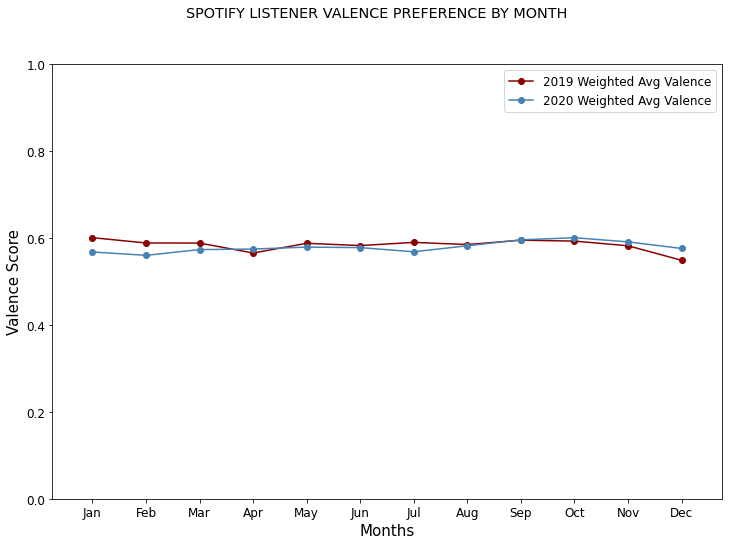

In [46]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019]

valence_2020 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020]
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH')         # Set up main title

y_axis = valence_2019['Valence_Stream%']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence_Stream%'], label="2019 Weighted Avg Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence_Stream%'], label="2020 Weighted Avg Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


In [18]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'New Zealand']   # Filter for country of your choice

country_covid_df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
53824,NZL,Oceania,New Zealand,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53825,NZL,Oceania,New Zealand,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53826,NZL,Oceania,New Zealand,2020-03-01,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53827,NZL,Oceania,New Zealand,2020-03-02,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53828,NZL,Oceania,New Zealand,2020-03-03,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931


In [19]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = country_covid_df[country_covid_df.date.str.contains(r'2020.*')]

country_covid__2020_df['Month'] = ''
country_covid__2020_df.head()

<ipython-input-19-9a7ab2cb5104>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_covid__2020_df['Month'] = ''


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
53824,NZL,Oceania,New Zealand,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53825,NZL,Oceania,New Zealand,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53826,NZL,Oceania,New Zealand,2020-03-01,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53827,NZL,Oceania,New Zealand,2020-03-02,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53828,NZL,Oceania,New Zealand,2020-03-03,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,


In [20]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
53824,NZL,Oceania,New Zealand,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,2
53825,NZL,Oceania,New Zealand,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,2
53826,NZL,Oceania,New Zealand,2020-03-01,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,3
53827,NZL,Oceania,New Zealand,2020-03-02,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,3
53828,NZL,Oceania,New Zealand,2020-03-03,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,3


In [21]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,2,1.0
1,3,646.0
2,4,832.0
3,5,25.0
4,6,24.0
5,7,34.0
6,8,190.0
7,9,96.0
8,10,111.0
9,11,100.0


In [22]:
# TIP: This next section is to add missing months. In the case of New Zealand, there was no data for January
# For other countries, it might vary. Here's how I added January to the dataframe:

country_covid__2020_groupby.loc[-1] = [1, 0]             # This adds a 1 (month of January) in the first columne 
                                                         # index 0), in the last row of the dataframe. 

country_covid__2020_groupby.index = country_covid__2020_groupby.index + 1   # shifts the index
country_covid__2020_groupby = country_covid__2020_groupby.sort_index()      # sorts by index

country_covid__2020_groupby = country_covid__2020_groupby.rename(columns={"new_cases": "New Cases"})

country_covid__2020_groupby


,Month,New Cases
0,1,0.0
1,2,1.0
2,3,646.0
3,4,832.0
4,5,25.0
5,6,24.0
6,7,34.0
7,8,190.0
8,9,96.0
9,10,111.0


In [23]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")

country_covid_valence_df

,Month,Valence,New Cases
0,1,0.572659,0.0
1,2,0.562224,1.0
2,3,0.568755,646.0
3,4,0.567754,832.0
4,5,0.567414,25.0
5,6,0.572654,24.0
6,7,0.574170,34.0
7,8,0.580730,190.0
8,9,0.589270,96.0
9,10,0.596465,111.0


In [24]:
# Add a new cases per million column

country_polulation = 5002100  #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

,Month,Valence,New Cases,New Cases Per Million
0,1,0.572659,0.0,0.000000
1,2,0.562224,1.0,0.199916
2,3,0.568755,646.0,129.145759
3,4,0.567754,832.0,166.330141
4,5,0.567414,25.0,4.997901
5,6,0.572654,24.0,4.797985
6,7,0.574170,34.0,6.797145
7,8,0.580730,190.0,37.984047
8,9,0.589270,96.0,19.191939
9,10,0.596465,111.0,22.190680


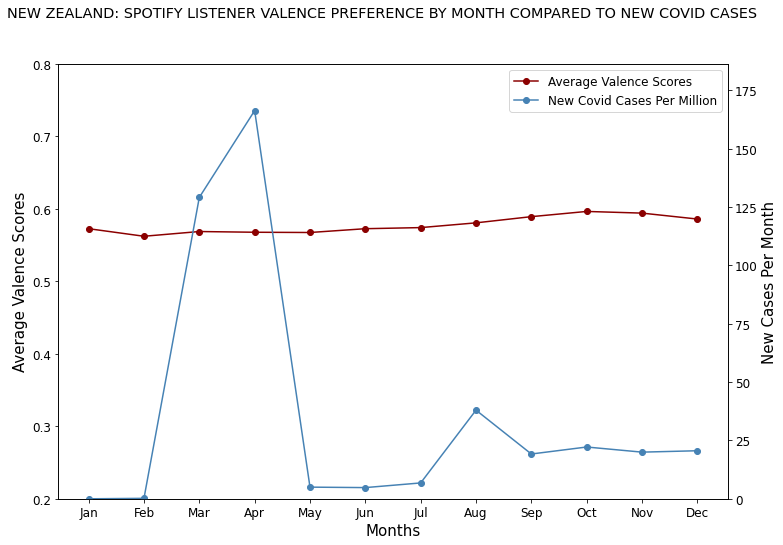

In [31]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('NEW ZEALAND: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence']
ax1.plot(months, ax1_ydata, label="Average Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()


In [32]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

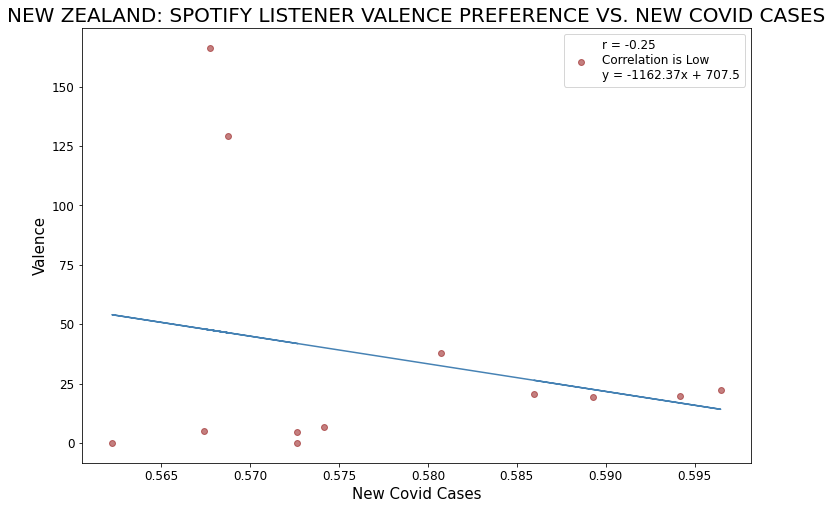

In [33]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('NEW ZEALAND: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"New Covid Cases")                                               # Set x axis label for subplot                  
plt.ylabel(f"Valence")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()